# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
data_dir = 'data/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

In [2]:
# necessary imports
import matplotlib.pyplot as plt
import numpy as np
import joblib as jb

import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms as Transforms
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from torch.nn import init

import torch.nn as nn
import torch.nn.functional as F

In [3]:
# define hyperparameters

PATH = 'data/'
IMAGE_SIZE = 64
BATCH_SIZE = 16
NUM_WORKERS = 0
EPOCHS = 10
PRINT_EVERY = 200
GPU = torch.cuda.is_available()

# model hyperparameters
DISCRIMINATOR_DIM = 32
GENERATOR_DIM = 64
Z_SIZE = 128 
SAMPLE_SIZE = BATCH_SIZE

## Create DataLoader

In [4]:
# define image processing pipeline
transforms = Compose([
    Transforms.Resize(IMAGE_SIZE),
    Transforms.ToTensor(),
    Transforms.Normalize(mean=[0.5, 0.5, 0.5], # scales pixel values between -1 and 1
                         std=[0.5, 0.5, 0.5]) 
])

# load image datases
images = ImageFolder(PATH, transforms)

# create data loader
real_image_loader = DataLoader(images, BATCH_SIZE, True,  num_workers=NUM_WORKERS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

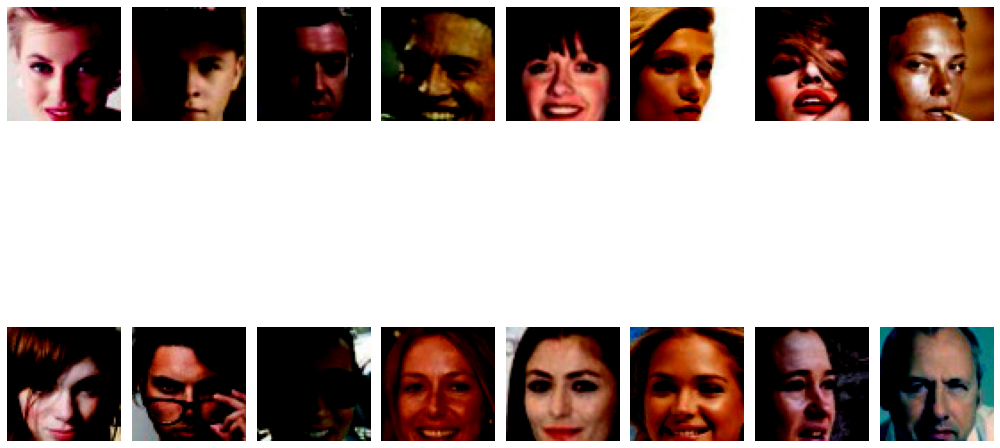

In [5]:
# view some of the images
images, _ = next(iter(real_image_loader))

fig, axes = plt.subplots(2, BATCH_SIZE//2, figsize=(14, 12))

for i, ax in enumerate(axes.ravel()):
    
    # convert the tensor into a numpy array and change the dimensions
    np_image = images[i].numpy()
    np_image = np.transpose(np_image, (1, 2, 0))
    
    # add the image to the grid
    ax.imshow(np_image)
    ax.set_axis_off()

plt.tight_layout()

* Note: The faces are already cropped

## Define the Generative Model 

    1. Discriminator
    2. Generator

### Discriminator

In [6]:
def convolution_block(in_channels, out_channels, kernel_size=4,
                          stride=2, padding=1, bias=False, batch_norm=True, dropout=0.25):
        '''
        Helper function that compiles a Conv2d, BatchNorm, and Dropout layers sequentially
        inputs:
            in_channels
            out_channels
            kernel_size
            stride
            padding
            bias
            batch_norm
            dropout        
        '''
        layers = []
        
        # define convolution layer
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, 
                                   stride=stride, padding=padding, bias=bias)) 
        
        if batch_norm:
            # define batch normalization layer
            layers.append(nn.BatchNorm2d(out_channels))
        
        if dropout:
            # add dropout
            layers.append(nn.Dropout(dropout))
            
        return nn.Sequential(*layers)

class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        '''
        Initialize the Discriminator Module
        inputs:
            conv_dim: integer, the depth of the first convolutional layer
        '''
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # define first convolutional layer (BatchNorm2d = False)
        self.input = convolution_block(3, conv_dim, batch_norm=False, dropout=0)
        
        # define additional convolutional layers (BatchNorm2d = True)
        self.conv1 = convolution_block(conv_dim, conv_dim*2)
        self.conv2 = convolution_block(conv_dim*2, conv_dim*4)
       
        # define final fully connected layer
        self.linear_dim = conv_dim * 4 * 8 * 8
        self.outputs = nn.Linear(self.linear_dim, 1)  
        
    
    def forward(self, x):
        '''
        Forward propagation of the neural network and returns the neural network's logits
        inputs:
            x: The input to the neural network
        '''
        # convolutional layer (BatchNorm2d = False)
        output = F.leaky_relu(self.input(x), 0.2, inplace=True)

         # convolutional layers (BatchNorm2d = True)
        output = F.leaky_relu(self.conv1(output), 0.2, inplace=True)
        output = F.leaky_relu(self.conv2(output), 0.2, inplace=True)
        
        # flatten
        output = output.view(-1, self.linear_dim)
    
        # final output layer
        output = self.outputs(output)        
        return output
    
# test the Discriminator class
tests.test_discriminator(Discriminator)

Tests Passed


### Generator

In [7]:
def deconvolution_block(in_channels, out_channels, kernel_size=4,
                          stride=2, padding=1, bias=False, batch_norm=True):
    '''
    inputs:
            in_channels
            out_channels
            kernel_size
            stride
            padding
            bias
            batch_norm        
    '''
    layers = []

    # define deconvolution layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, 
                               stride=stride, padding=padding, bias=bias)) 

    # define batch normalization layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    # add activation layer
    layers.append(nn.ReLU(inplace=True))

    return nn.Sequential(*layers) 

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        '''
        Initialize the Generator Module
        inputs
            z_size: The length of the input latent vector, z
            conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        '''        
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # dense layer with output dimensions as the discriminatoir's last convolution layer
        self.input = nn.Linear(z_size, conv_dim * 4 * 8 * 8)
        
        # define additional convolutional layers (BatchNorm2d = True)
        self.deconv1 = deconvolution_block(conv_dim*4, conv_dim*2)
        self.deconv2 = deconvolution_block(conv_dim*2, conv_dim)
        
        self.outputs = nn.ConvTranspose2d(conv_dim, 3, kernel_size=4, 
                                       stride=2, padding=1, bias=False)
        

    def forward(self, x):
        '''
        Forward propagation of the neural network. Returns a Tensor image as output
        inputs:
            x: The input to the neural network     
        '''
        
        # define feedforward behavior
        output = self.input(x)
        output = output.view(-1, self.conv_dim*4, 8, 8) # reshape
        
        # hidden transpose conv layers + relu
        output = self.deconv1(output)
        output = self.deconv2(output)
        
        output = torch.tanh(self.outputs(output))
        return output    

# test the Generator class
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

* Initalizing the Discriminator weights to a normal distribution centered around 0 with a std of 0.02.
* Initalizing the Generatpr weights to a Xavier's distribution centered around 0 with a std of 0.02.

In [8]:
# reading online I wanted to try xavier for the generator (recommended for tanh activation)
# however, this is part of the exercise :(

def weights_init_normal(m, init_gain=0.02):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    classname = m.__class__.__name__
    
    # intitalize convolution for convolution and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1): 
        
        # set weights to distribute normally around 0 with std of 0.02 
        init.normal_(m.weight.data, 0.0, init_gain)
        
        # set the bias to 0 if the layer class has bias
        if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
    
    # initalize batch normalization layers
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, 0.02)
            init.constant_(m.bias.data, 0.0)

In [9]:
def weights_init_xavier(m, init_gain=0.02):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    classname = m.__class__.__name__
    
    # intitalize convolution for convolution and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1): 
        
        # set weights to distribute normally around 0 with std of 0.02 
        init.xavier_normal_(m.weight.data, gain=init_gain)
        
        # set the bias to 0 if the layer class has bias
        if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
    
    # initalize batch normalization layers
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, 0.02)
            init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [10]:
# instanciate discriminator and initalize weights
D = Discriminator(DISCRIMINATOR_DIM)
D.apply(weights_init_normal)

# validate discriminator architecture
print(D)

# instanciate generator
G = Generator(Z_SIZE, GENERATOR_DIM)
G.apply(weights_init_xavier)

# validate generator architecture
print(G)

Discriminator(
  (input): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
  )
  (outputs): Linear(in_features=8192, out_features=1, bias=True)
)
Generator(
  (input): Linear(in_features=128, out_features=16384, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [11]:
def real_loss(D_out, batch_size, gpu, smoothing=False):
    '''
    Calculates how close discriminator outputs are to being real and return the "real" loss.
    input:
        D_out: discriminator logits
    '''
    # help prevent discriminator overfitting to real images
    labels = torch.ones(batch_size) * 0.9 if smoothing else torch.ones(batch_size)
    
    if gpu:
        labels = labels.cuda()
        
    # BCEWLL
    criterion = nn.BCEWithLogitsLoss()
    
    # eliminate batch size and compute the loss
    return criterion(D_out.squeeze(), labels)

def fake_loss(D_out, batch_size, gpu):
    '''
    Calculates how close discriminator outputs are to being fake and return the "fake" loss
    input:
       D_out: discriminator logits
    '''
    
    # fake image labels
    labels = torch.zeros(batch_size)
    
    if gpu:
        labels = labels.cuda()
        
    # BCEWLL
    criterion = nn.BCEWithLogitsLoss()
    
    # eliminate batch size and compute the loss
    return criterion(D_out.squeeze(), labels)

## Optimizers

Define optimizers for your models with appropriate hyperparameters.

In [12]:
import torch.optim as optim

b1 = 0.5
b2 = 0.999 

# Create optimizers for the discriminator D and generator G
discriminator_optim = optim.Adam(D.parameters(), lr=5e-5, betas=(b1, b2)) # used in the DCGAN paper
generator_optim = optim.Adam(G.parameters(), lr=5e-5, betas=(b1, b2)) # used in the DCGAN paper

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [13]:
def train_discriminator(discriminator, optimizer, inputs, gpu, batch_size, real=True, generator=None):
    '''
    
    '''
    if real:
        discriminator_output = discriminator(inputs)
        discriminator_loss = real_loss(discriminator_output, batch_size, gpu, smoothing=True)
        
    else:
        # generate fake images
        fake_images = generator(inputs) 
        
        # train on fake images
        discriminator_output = discriminator(fake_images)
        discriminator_loss = fake_loss(discriminator_output, batch_size, gpu)
        
    return discriminator_loss

def train_generator(generator, discriminator, optimizer, inputs, gpu, batch_size):
    '''
    
    '''
    # generate fake images
    fake_images = generator(inputs) 

    # train on fake images
    generator_output = discriminator(fake_images)
    generator_loss = real_loss(generator_output, batch_size, gpu, smoothing=False)
    
    return generator_loss
    
    
def generate_sample_images(sample_size, z_size):
    '''
    
    '''
    # get some fixed data for sampling. these are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample = np.random.uniform(-1, 1, size=(sample_size, z_size))
    sample = torch.from_numpy(sample).float()
    
    return sample

In [ ]:
total_loss = []

if GPU:
    D.cuda()
    G.cuda()
    
for epoch in range(2):
    for n, (real_images, _) in enumerate(real_image_loader):
        
        # training mode
        G.train() 
        D.train() 
        
        # TRAIN DISCRIMINATOR
        
        # clear gradients
        discriminator_optim.zero_grad()
        
        # train the discriminator on real images
        if GPU:
            real_images = real_images.cuda()
            
        discriminator_real_image_loss = train_discriminator(D, discriminator_optim, 
                                                            real_images, GPU, BATCH_SIZE)
        
        # train the discriminator on fake images
        fakes = generate_sample_images(BATCH_SIZE, Z_SIZE)
        
        if GPU:
            fakes = fakes.cuda()
            
        discriminator_fake_image_loss = train_discriminator(D, discriminator_optim, 
                                                            fakes, GPU, BATCH_SIZE,
                                                            real=False, generator=G)
        
        # compute discriminator total loss and perform backprop
        discriminator_loss = discriminator_real_image_loss + discriminator_fake_image_loss
        discriminator_loss.backward()
        discriminator_optim.step()
        
        # TRAIN GENERATOR 
        
        # clear gradients
        generator_optim.zero_grad()
        
        # train the generator on adverserial loss
        fakes = generate_sample_images(BATCH_SIZE, Z_SIZE)
        
        if GPU:
            fakes = fakes.cuda()
            
        # compute generator loss
        generator_loss = train_generator(G, D, generator_optim, fakes, GPU, BATCH_SIZE)
        generator_loss.backward()
        generator_optim.step()
        
        
        # print some loss stats
        if n % PRINT_EVERY == 0:
            
            # note loss
            total_loss.append((discriminator_loss.item(), generator_loss.item()))
            
            # print discriminator and generator loss
            print(f'Epoch: {epoch+1}/{EPOCHS} || D Loss: {discriminator_loss} || G Loss: {generator_loss}')
            
        # save model weights
                
            
# clear GPU memory
if GPU:
    D.cpu()
    G.cpu()
    real_images = real_images.cpu()
    fakes = fakes.cpu()

In [ ]:
# evaluate geneerator performance    

G.eval() 
with torch.no_grad():
    constant_sample = generate_sample_images(SAMPLE_SIZE, Z_SIZE)
    samples_z = G(constant_sample)
    
# view samples

In [ ]:
def train(D, G, n_epochs, train_on_gpu, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(real_image_loader):

            batch_size = real_images.size(0)
            #real_images = scale(real_images)
            
            # DISCRIMINATOR TRAIN
            d_optimizer.zero_grad()
            
            # 1.1 Train the discriminator on real images
            real_images = real_images.cuda() if train_on_gpu else real_images
            disc_real_train = D(real_images)
            d_real_loss = real_loss(disc_real_train, batch_size, train_on_gpu, smoothing=True)
            
            # 1.2 Train the discriminator on fake images
            fake_arr = np.random.uniform(-1, 1, size=(batch_size, z_size))
            fake_arr = torch.from_numpy(fake_arr).float()
            fake_arr = fake_arr.cuda() if train_on_gpu else fake_arr
            fake_image = G(fake_arr) 
            
            disc_fake_train = D(fake_image)
            d_fake_loss = fake_loss(disc_fake_train, batch_size, train_on_gpu)
            
            # compute discriminator total loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            # GENERATOR TRAIN
            g_optimizer.zero_grad()
            
            # 2. Train the generator with an adversarial loss
            fake_arr = np.random.uniform(-1, 1, size=(batch_size, z_size))
            fake_arr = torch.from_numpy(fake_arr).float()
            fake_arr = fake_arr.cuda() if train_on_gpu else fake_arr
            fake_image = G(fake_arr) 
            
            # compute loss on fake images and real images label
            disc_fake_train = D(fake_image)
            
            # compute generator loss and perform backprop
            g_loss = real_loss(disc_fake_train, batch_size, train_on_gpu, smoothing=False)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # unload gpu memory
    if train_on_gpu:
        D.cpu()
        G.cpu()
        real_images = real_images.cpu()
        fake_image = fake_image.cpu()
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [ ]:
# set number of epochs 
n_epochs = 15

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs, train_on_gpu, print_every=150)

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((64,64,3)))
        
    plt.show()

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples, and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result

Question: What do you notice about your generated samples, and how might you improve this model?
Not surprisingly, the model creates low-resolution images. Nevertheless, the generated samples look decent (granted, some of them seem like Frankenstein). Unfortunately, more extended training doesn't improve the pictures. There are 32k images in our dataset. This number is several orders of magnitudes smaller than the number of people that exist (or existed). Because people of color weren't well represented, I expected to generate more realistic-looking faces with light-colored complexion. Also, I suspect that the model would not create as many faces with colors.

To improve the generative model, I would probably need to restrain the discriminator even more than I have. So, I started with a 0.9 smoothing factor and lowered it to 0.75. Furthermore, I noticed that the discriminator learns a lot faster than the generator and that training the model for more time did not improve the results. 

To prevent the discriminator from overfitting and improve the generative model outputs, I would:

1. Remove one of the convolutional layers.
2. Add noise to the authentic images. I would likely try to implement a "noise decay" strategy. Meaning, I would add more noise to the pictures at the beginning of the training and reduce the amount of noise as the training process continues.

Additionally, I would try changing the generator's weight initialization strategy to Xavier's initialization. I read online it yielded better results than the normal distribution strategy when using the tanh activation function.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.